In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from pandas.api.types import is_string_dtype   
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

In [231]:
dataset = pd.read_csv('kidney_disease.csv')

In [232]:
pd.set_option('display.max_columns', None)
dataset

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,49.0,0.5,150.0,4.9,15.7,47,6700,4.9,no,no,no,good,no,no,notckd
396,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,31.0,1.2,141.0,3.5,16.5,54,7800,6.2,no,no,no,good,no,no,notckd
397,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,26.0,0.6,137.0,4.4,15.8,49,6600,5.4,no,no,no,good,no,no,notckd
398,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,50.0,1.0,135.0,4.9,14.2,51,7200,5.9,no,no,no,good,no,no,notckd


In [233]:
dataset.isnull().sum()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

In [234]:
dataset[['htn','dm','cad','pe','ane']] = dataset[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
dataset[['rbc','pc']] = dataset[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})
dataset[['pcc','ba']] = dataset[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})
dataset[['appet']] = dataset[['appet']].replace(to_replace={'good':1,'poor':0,'no':np.nan})
dataset['classification'] = dataset['classification'].replace(to_replace={'ckd':0.0,'ckd\t':0.0,'notckd':1.0,'no':1.0})
dataset.rename(columns={'classification':'class'},inplace=True)


In [235]:
dataset['pe'] = dataset['pe'].replace(to_replace='good',value=0) # Not having pedal edema is good
dataset['appet'] = dataset['appet'].replace(to_replace='no',value=0)
dataset['cad'] = dataset['cad'].replace(to_replace='\tno',value=0)
dataset['dm'] = dataset['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})
dataset.drop('id',axis=1,inplace=True)

In [236]:
dataset['pcv'] = pd.to_numeric(dataset['pcv'], errors='coerce')
dataset['wc'] = pd.to_numeric(dataset['wc'], errors='coerce')
dataset['rc'] = pd.to_numeric(dataset['rc'], errors='coerce')

In [237]:
dataset

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,0.0,0.0,0.0,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,7.0,50.0,1.020,4.0,0.0,NaN,0.0,0.0,0.0,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,140.0,49.0,0.5,150.0,4.9,15.7,47.0,6700.0,4.9,0.0,0.0,0.0,1.0,0.0,0.0,1.0
396,42.0,70.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,75.0,31.0,1.2,141.0,3.5,16.5,54.0,7800.0,6.2,0.0,0.0,0.0,1.0,0.0,0.0,1.0
397,12.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,100.0,26.0,0.6,137.0,4.4,15.8,49.0,6600.0,5.4,0.0,0.0,0.0,1.0,0.0,0.0,1.0
398,17.0,60.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,114.0,50.0,1.0,135.0,4.9,14.2,51.0,7200.0,5.9,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [238]:
col_list=dataset.columns.tolist()
for i in col_list:
    print(i+" ")
    print(dataset[i].median())

age 
55.0
bp 
80.0
sg 
1.02
al 
0.0
su 
0.0
rbc 
0.0
pc 
0.0
pcc 
0.0
ba 
0.0
bgr 
121.0
bu 
42.0
sc 
1.3
sod 
138.0
pot 
4.4
hemo 
12.649999999999999
pcv 
40.0
wc 
8000.0
rc 
4.8
htn 
0.0
dm 
0.0
cad 
0.0
appet 
1.0
pe 
0.0
ane 
0.0
class 
0.0


In [239]:
dataset = dataset.fillna(dataset.median())

In [240]:
dataset

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,0.0,0.0,0.0,0.0,121.0,36.0,1.2,138.0,4.4,15.4,44.0,7800.0,5.2,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,7.0,50.0,1.020,4.0,0.0,0.0,0.0,0.0,0.0,121.0,18.0,0.8,138.0,4.4,11.3,38.0,6000.0,4.8,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,53.0,1.8,138.0,4.4,9.6,31.0,7500.0,4.8,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,26.0,1.4,138.0,4.4,11.6,35.0,7300.0,4.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,140.0,49.0,0.5,150.0,4.9,15.7,47.0,6700.0,4.9,0.0,0.0,0.0,1.0,0.0,0.0,1.0
396,42.0,70.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,75.0,31.0,1.2,141.0,3.5,16.5,54.0,7800.0,6.2,0.0,0.0,0.0,1.0,0.0,0.0,1.0
397,12.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,100.0,26.0,0.6,137.0,4.4,15.8,49.0,6600.0,5.4,0.0,0.0,0.0,1.0,0.0,0.0,1.0
398,17.0,60.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,114.0,50.0,1.0,135.0,4.9,14.2,51.0,7200.0,5.9,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [241]:
dataset.isnull().sum()

age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wc       0
rc       0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64

In [242]:
category = ['sg','al','su','rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane']
numerical = ['age','bp','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']

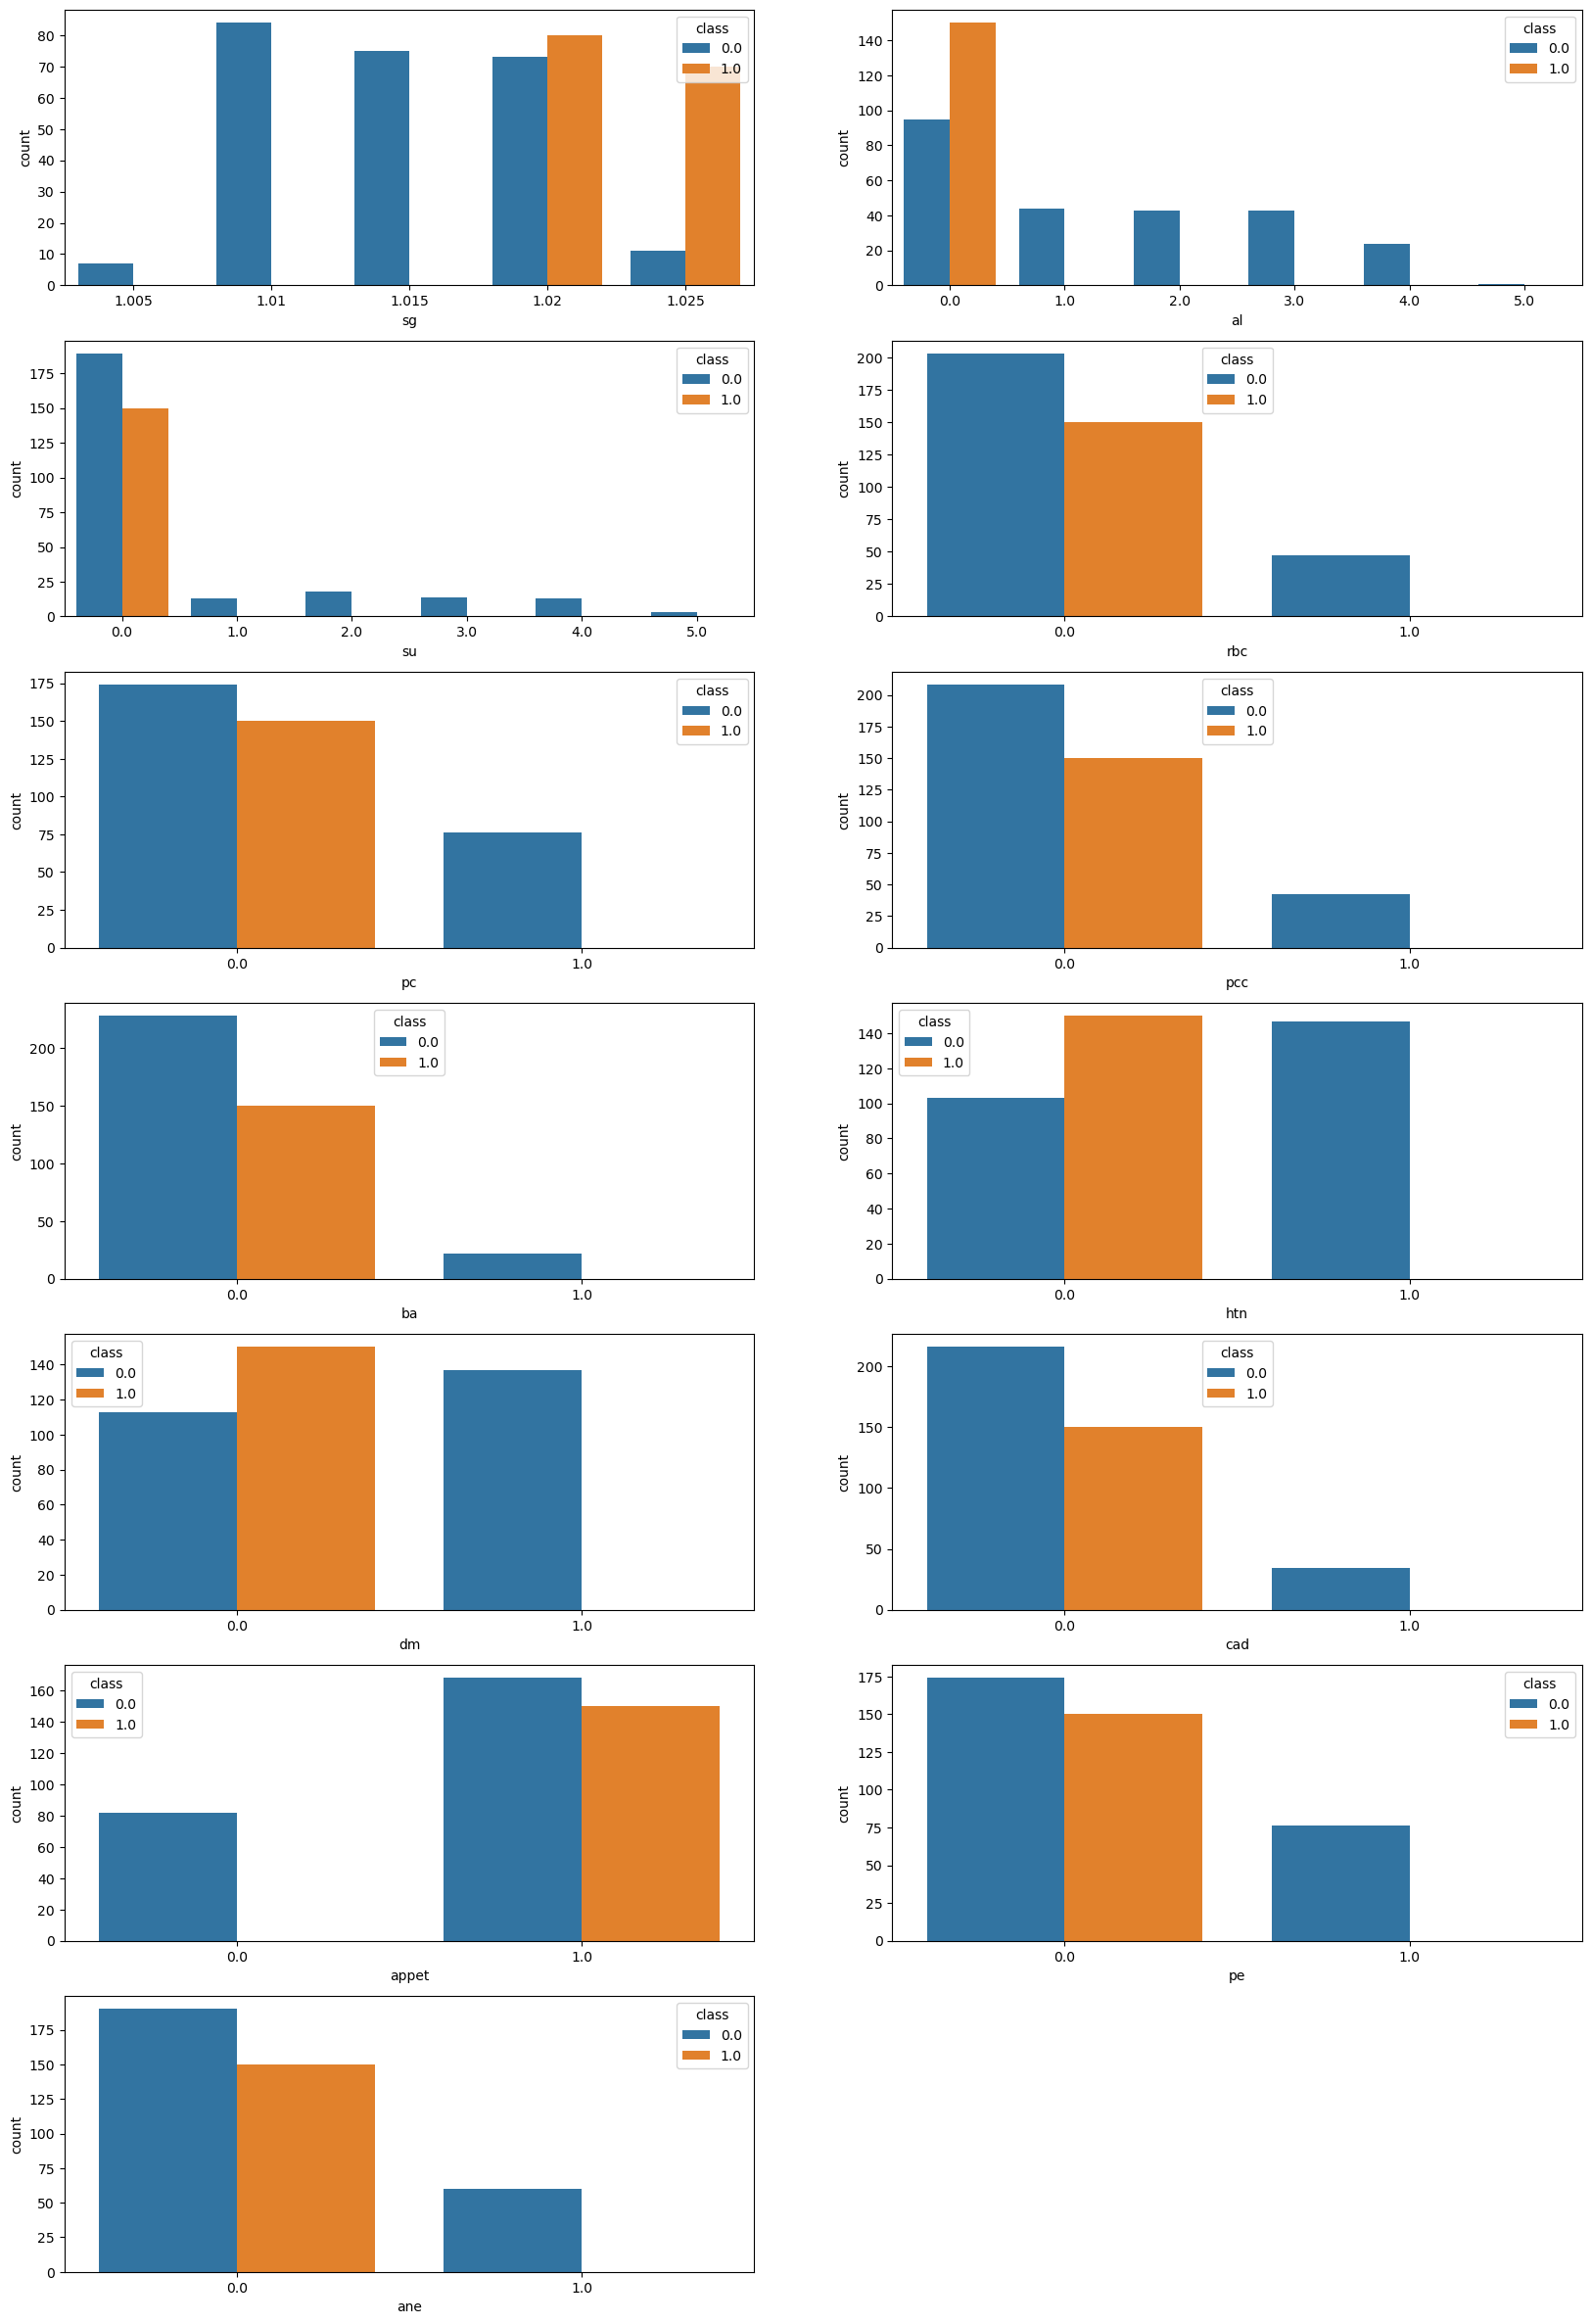

In [243]:
plt.figure(figsize = (20,30))
plot_number = 1
for column in category:
    if plot_number <= 14:
        ax = plt.subplot(7,2,plot_number)
        sns.countplot(x =column,hue='class',data = dataset)
    plot_number += 1
plt.show()

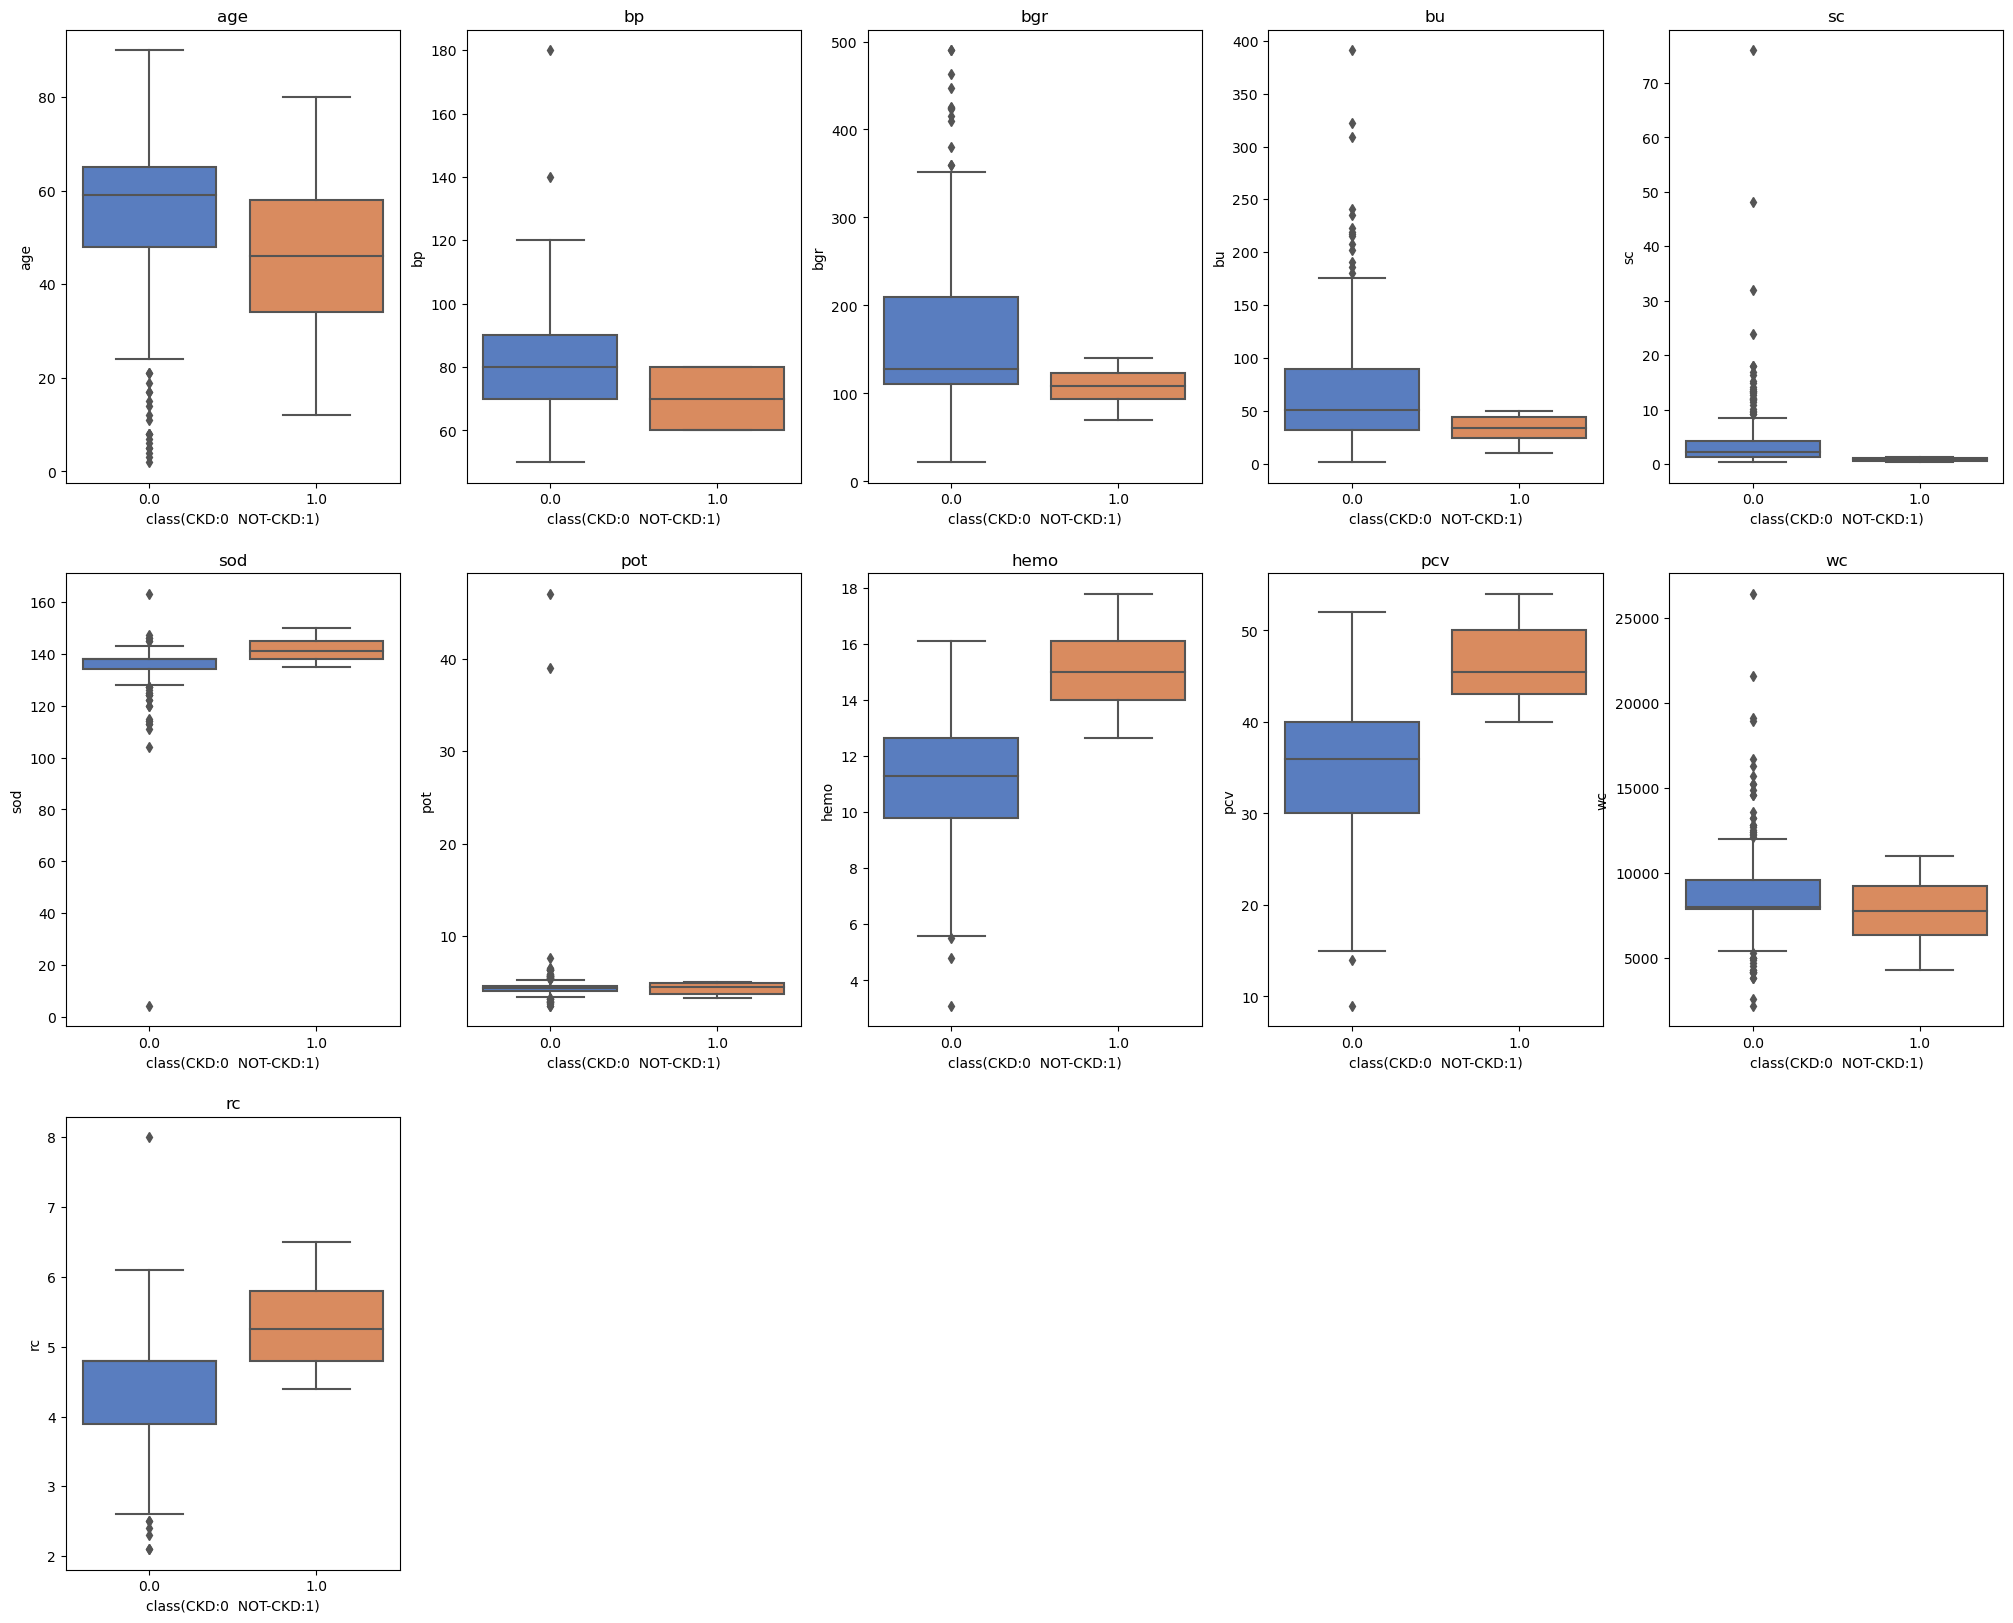

In [244]:
plt.figure(figsize = (25,20))
plot_number = 1
for column in numerical:
    if plot_number <= 14:
        ax = plt.subplot(3, 5, plot_number)
        sns.boxplot(data=dataset,
            x="class",
            y=column,
            palette = "muted"
           )
        ax.set_title(column)
        plt.xlabel("class(CKD:0  NOT-CKD:1)")
    plot_number += 1
plt.show()

In [245]:
co_mat = dataset.corr()

<AxesSubplot:>

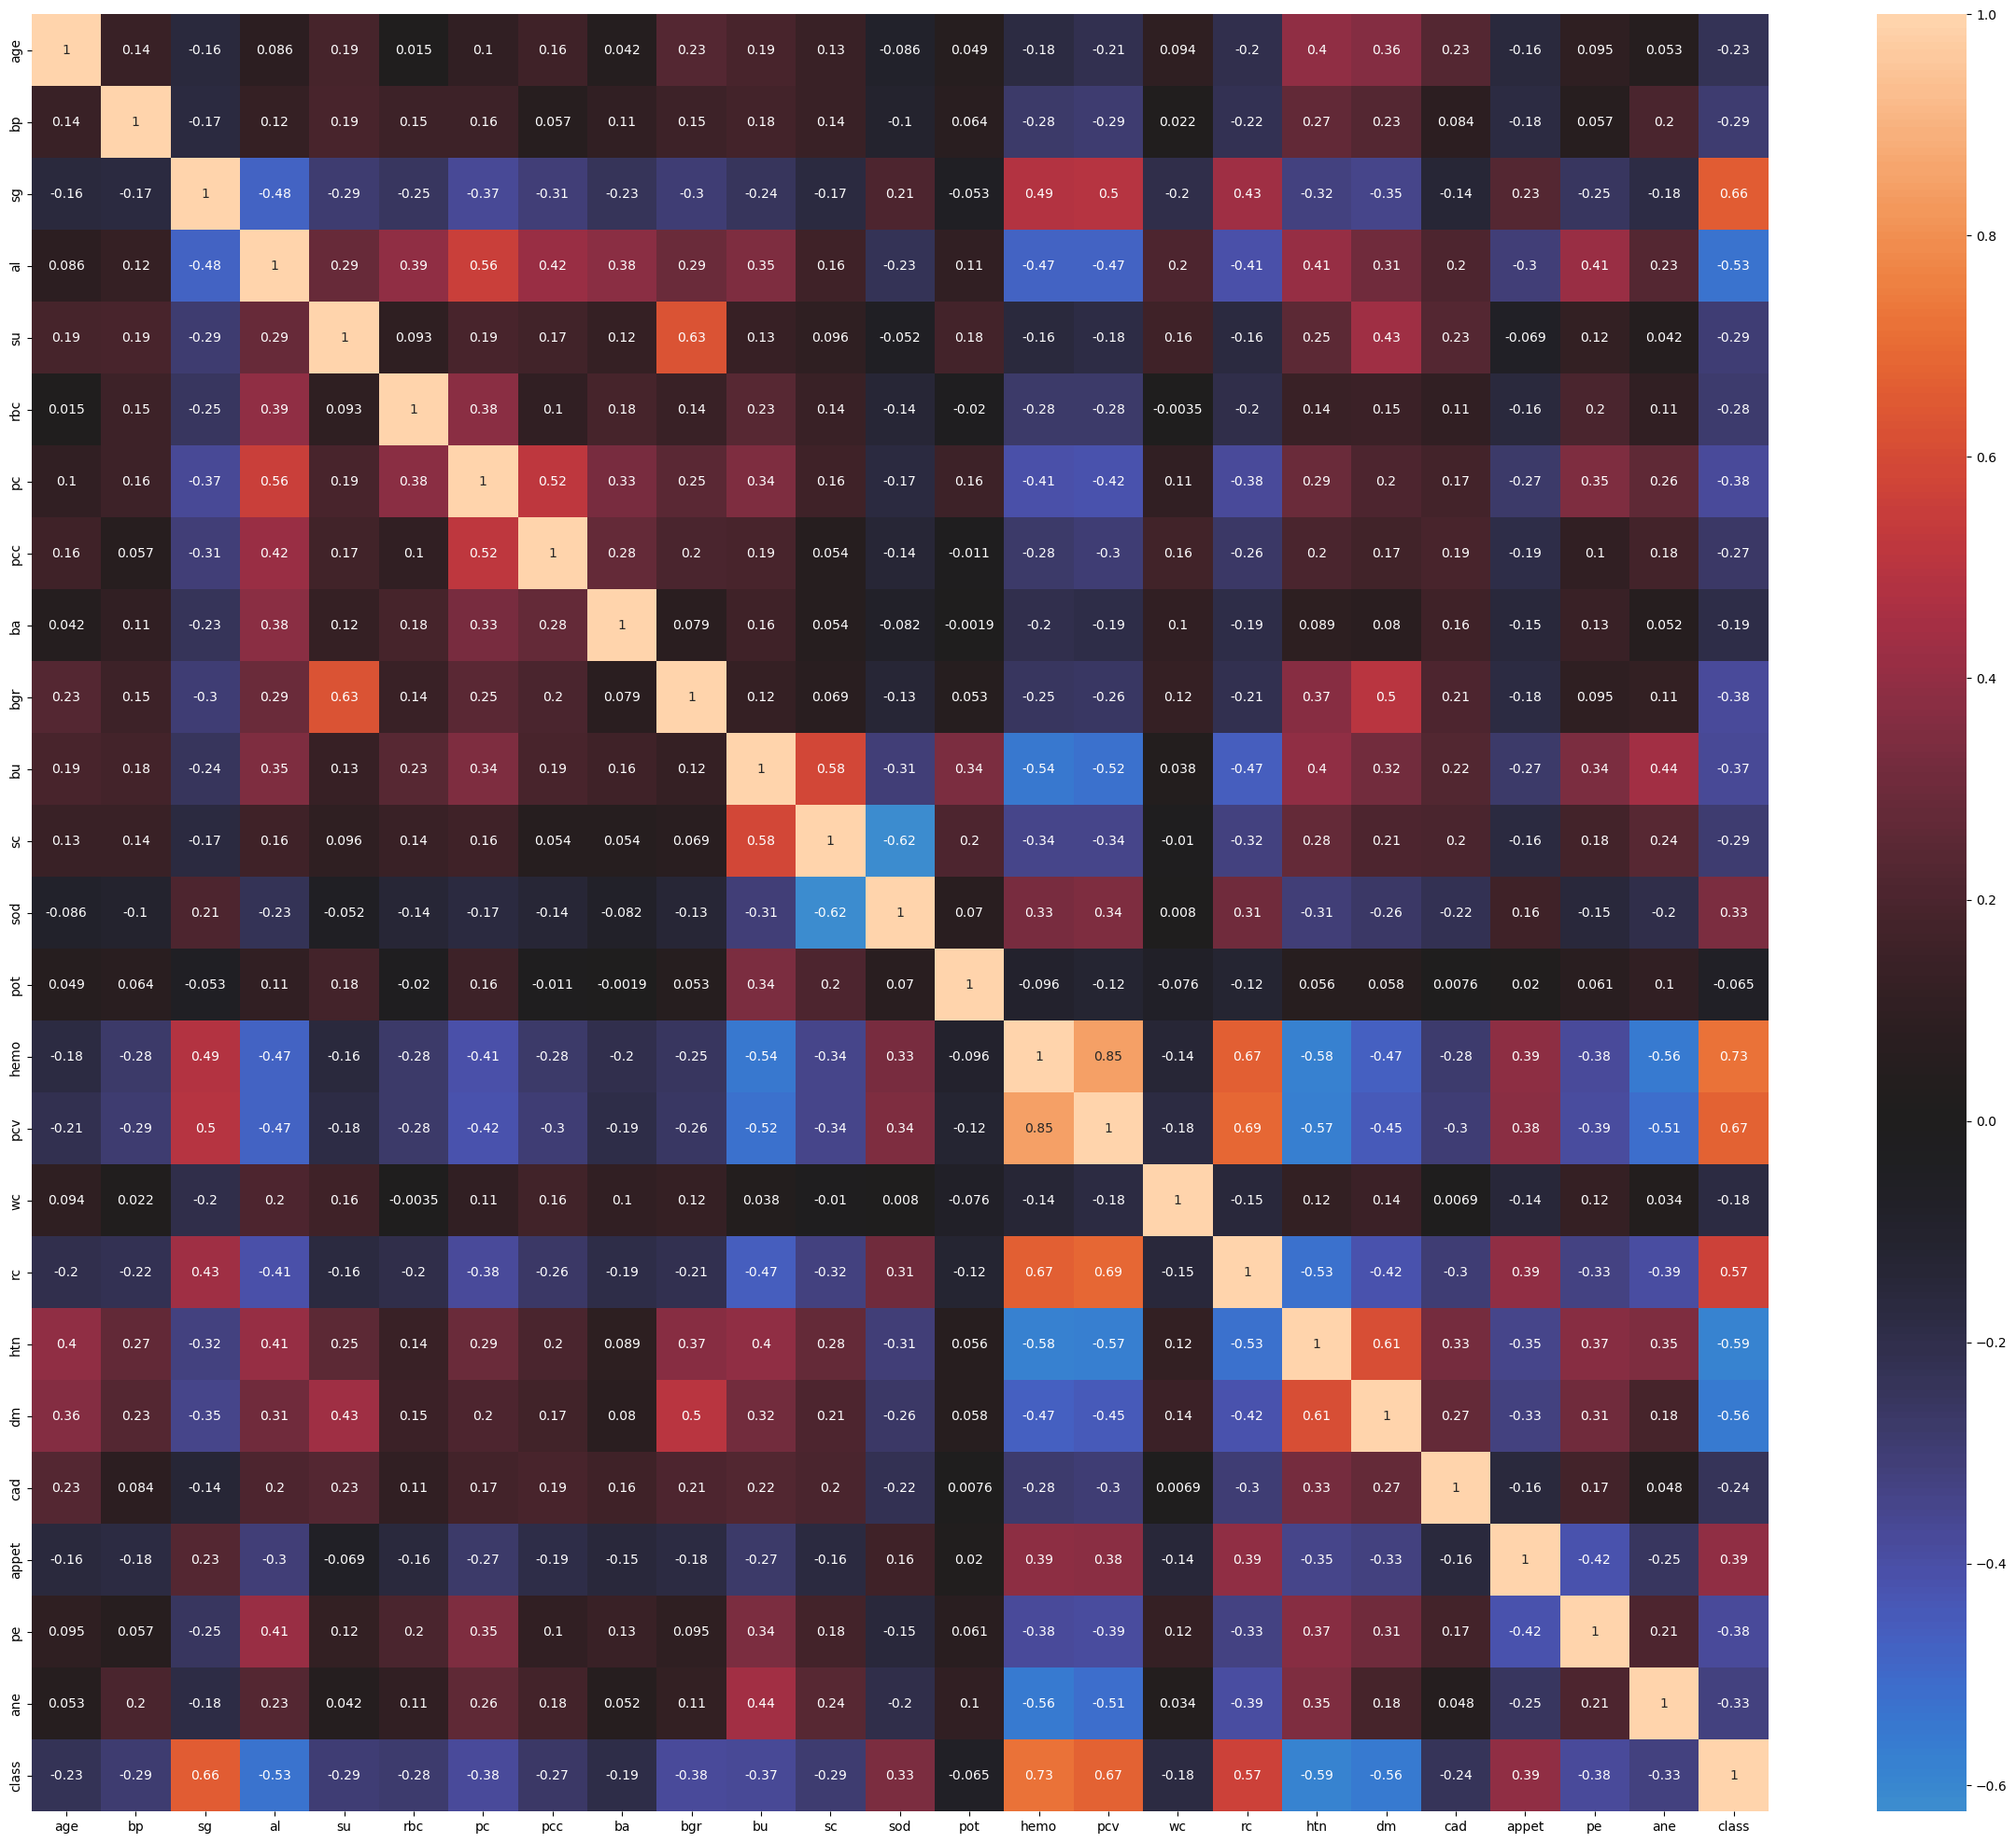

In [246]:
plt.figure(1, figsize=(30,25))
sns.heatmap(co_mat,center=0, annot=True, cbar=True)

In [247]:
X = dataset.drop('class', axis=1)
y = dataset['class']

In [248]:
#DECISION TREE



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




hemo : 0.7367195767195767
sg : 0.19367071906512118
bu : 0.020086584503860985
htn : 0.019662614268212204
rc : 0.014906832298136618
pcv : 0.014222222222222221
sc : 0.0007314509228700961


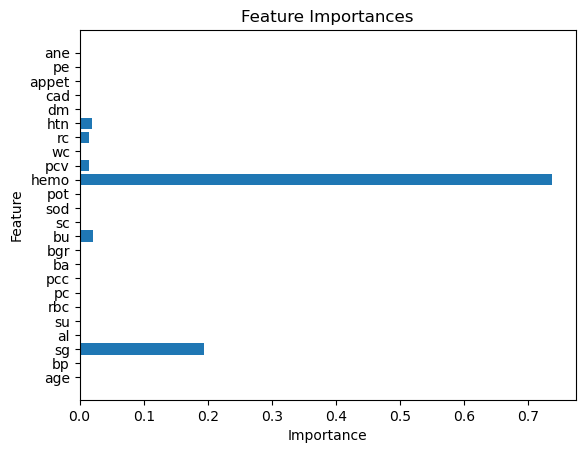

In [249]:
dt = DecisionTreeClassifier(random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
print("\n")
#print("Average accuracy score:", sum(scores)/len(scores))
#print("\n")

importances = dt.feature_importances_
features = X.columns.tolist()

# Create a dictionary that maps feature names to importance scores
importance_dict = {features[i]: importances[i] for i in range(len(features))}

# Sort the dictionary by importance scores in descending order
sorted_dict = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

for i in range(7):
    print(sorted_dict[i][0], ":", sorted_dict[i][1])


plt.barh(features, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()


Confusion matrix:
[[245   5]
 [  4 146]]


Text(50.722222222222214, 0.5, 'True Class')

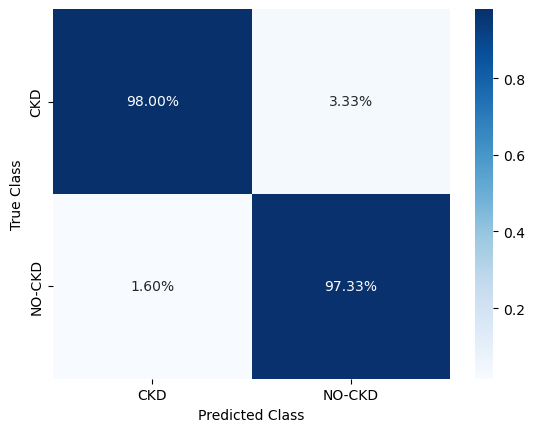

In [250]:
y_true = []
y_pred = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt.fit(X_train, y_train)
    y_true.extend(y_test)
    y_pred.extend(dt.predict(X_test))

cm = confusion_matrix(y_true, y_pred)

print("Confusion matrix:")
print(cm)





cm_normalized=cm/np.sum(cm,axis=1)
xl=['CKD', 'NO-CKD']
yl=['CKD','NO-CKD']
sns.heatmap(cm_normalized,cmap="Blues",fmt='.2%',annot=True,cbar_kws={"orientation":"vertical"},xticklabels=xl,yticklabels=yl)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")


In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a decision tree classifier to perform feature selection
#dt = DecisionTreeClassifier(random_state=42)
#dt.fit(X_train, y_train)

# Get the feature importances and select the top 10 features
#importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]
selected_features = indices[:7]

X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

# Define the ensemble model with the selected features
clf1 = LogisticRegression(random_state=42)
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = SVC(random_state=42)
clf4 = KNeighborsClassifier()
clf5 = XGBClassifier(random_state=42)

ensemble = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3), ('knn', clf4), ('xgb', clf5)], voting='hard')

# Evaluate the accuracy using 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
acc_scores = cross_val_score(ensemble, X_train_selected, y_train, cv=kf, scoring='accuracy')

print("Selected features:", X_train.columns[selected_features])
print("Accuracy: {:.6f} %".format(acc_scores.mean()*100))



Selected features: Index(['hemo', 'sg', 'bu', 'htn', 'rc', 'pcv', 'sc'], dtype='object')
Accuracy: 95.312500 %


In [252]:
# XGBOOST



hemo : 0.52752113
sg : 0.19372477
sc : 0.08610082
al : 0.075645894
rc : 0.05673393
sod : 0.03298834
age : 0.01779807
bu : 0.008389759
wc : 0.0007278968
bgr : 0.00036936198


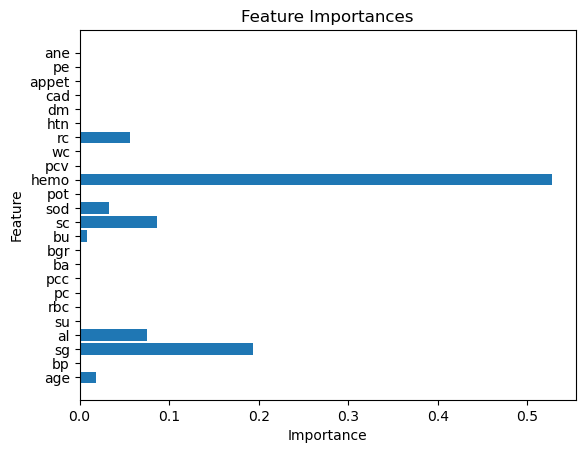

In [253]:
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    xg_cl.fit(X_train, y_train)
    y_pred = xg_cl.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
#print("\n")
#print("Average accuracy score:", sum(scores)/len(scores))
#print("\n")


importances = xg_cl.feature_importances_
features = X.columns.tolist()

importance_dict = {features[i]: importances[i] for i in range(len(features))}


sorted_dict = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

for i in range(10):
    print(sorted_dict[i][0], ":", sorted_dict[i][1])


plt.barh(features, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()

Confusion matrix:
[[246   4]
 [  5 145]]


Text(50.722222222222214, 0.5, 'True Class')

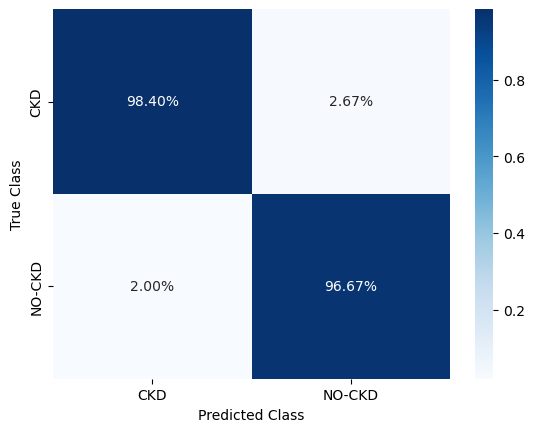

In [254]:
y_true = []
y_pred = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    xg_cl.fit(X_train, y_train)
    y_true.extend(y_test)
    y_pred.extend(xg_cl.predict(X_test))

cm = confusion_matrix(y_true, y_pred)

print("Confusion matrix:")
print(cm)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)


cm_normalized=cm/np.sum(cm,axis=1)
xl=['CKD', 'NO-CKD']
yl=['CKD','NO-CKD']
sns.heatmap(cm_normalized,cmap="Blues",fmt='.2%',annot=True,cbar_kws={"orientation":"vertical"},xticklabels=xl,yticklabels=yl)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")


In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

indices = np.argsort(importances)[::-1]
selected_features = indices[:10]

X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

acc_scores = cross_val_score(ensemble, X_train_selected, y_train, cv=kf, scoring='accuracy')

# Print the selected features and the accuracy
print("Selected features:", X_train.columns[selected_features])
print("Accuracy: {:.6f} %".format(acc_scores.mean()*100))


Selected features: Index(['hemo', 'sg', 'sc', 'al', 'rc', 'sod', 'age', 'bu', 'wc', 'bgr'], dtype='object')
Accuracy: 98.125000 %


In [256]:
#RFE
#-------------------------------------------------------------------------------------------------------------------------------

In [257]:
selector = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=8)

selector.fit(X_train, y_train)

selected_features = selector.get_support(indices=True)

X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

print("Best Features:",selected_features)
print("Feature ranking:", selector.ranking_)
for i, rank in enumerate(selector.ranking_):
    if(rank==1):
        print(f"{i+1}. {X_train.columns[i]}: {rank}")
#cv_scores=cross_val_score(rfe,X,y,cv=10)
#print("accuracy:",cv_scores.mean())

Best Features: [ 2  3 11 14 15 17 18 19]
Feature ranking: [ 5  6  1  1 10 13 11 16 15  2  4  1  3  7  1  1 12  1  1  1 17  8  9 14]
3. sg: 1
4. al: 1
12. sc: 1
15. hemo: 1
16. pcv: 1
18. rc: 1
19. htn: 1
20. dm: 1


In [258]:
#----------------------------------------------------------------------------------------------------------------------------



#-----------------------------------------------------------------------------------------------------------------------------

Text(50.722222222222214, 0.5, 'True Class')

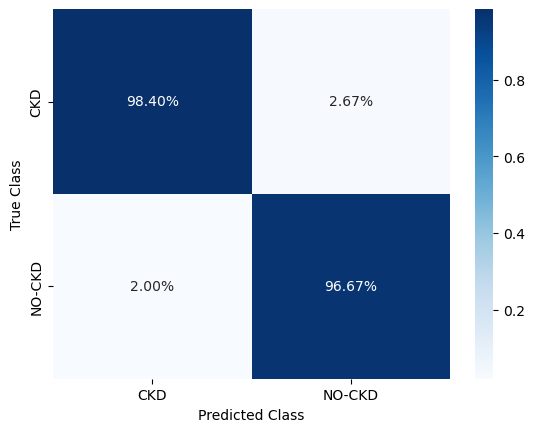

In [259]:
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score

# Train the random forest classifier on the selected features
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_selected, y_train)

# Predict the target values on the test set
y_pred = clf.predict(X_test_selected)

# Calculate evaluation metrics

cm_normalized=cm/np.sum(cm,axis=1)
xl=['CKD', 'NO-CKD']
yl=['CKD','NO-CKD']
sns.heatmap(cm_normalized,cmap="Blues",fmt='.2%',annot=True,cbar_kws={"orientation":"vertical"},xticklabels=xl,yticklabels=yl)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

In [260]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
acc_scores = cross_val_score(ensemble, X_train_selected, y_train, cv=kf, scoring='accuracy')

print("Selected features:", X_train.columns[selected_features])
print("Accuracy: {:.6f} %".format(acc_scores.mean()*100))

Selected features: Index(['sg', 'al', 'sc', 'hemo', 'pcv', 'rc', 'htn', 'dm'], dtype='object')
Accuracy: 97.812500 %


In [261]:
#LDA
#-------------------------------------------------------------------------------------------------------------------------------

In [262]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

lda = LDA(n_components=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform LDA for feature selection
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)


"""
scores = []
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
"""

#print("Average accuracy score:", sum(scores)/len(scores))
#print("\n")



'\nscores = []\nfor train_index, test_index in cv.split(X):\n    X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n    y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n    lda.fit(X_train, y_train)\n    y_pred = lda.predict(X_test)\n    scores.append(accuracy_score(y_test, y_pred))\n'

Text(50.722222222222214, 0.5, 'True Class')

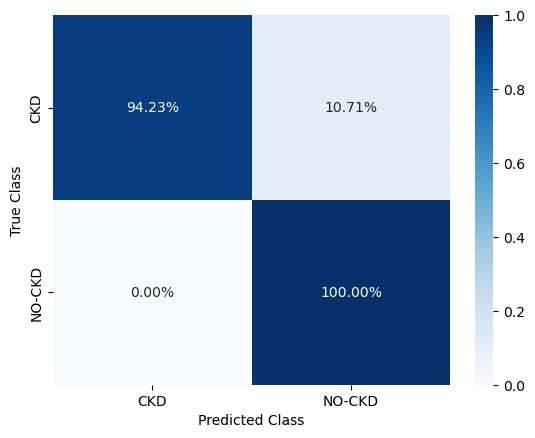

In [263]:
#lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)


conf_matrix = confusion_matrix(y_test, y_pred)


cm_normalized = conf_matrix / np.sum(conf_matrix, axis=1)

xl = ['CKD', 'NO-CKD']
yl = ['CKD', 'NO-CKD']

sns.heatmap(cm_normalized, cmap="Blues", fmt='.2%', annot=True, cbar_kws={"orientation":"vertical"}, xticklabels=xl, yticklabels=yl)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")


In [264]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
acc_scores = cross_val_score(ensemble, X_train_lda, y_train, cv=kf, scoring='accuracy')

In [265]:
#PCA
#-----------------------------------------------------------------------------------------------------------------------------

In [266]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

pca = PCA(n_components=5)
clf = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform PCA
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


print("Accuracy for PCA: {:.6f} %".format(acc_scores.mean()*100))

Accuracy for PCA: 98.125000 %


Confusion matrix:
[[208.  42.]
 [ 34. 116.]]


Text(50.722222222222214, 0.5, 'True Class')

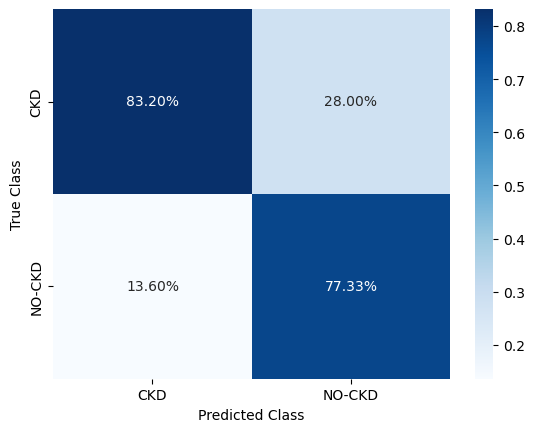

In [267]:
conf_matrix = np.zeros((2, 2))

y_true=[]
y_pred=[]

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    pca.fit(X_train)
    
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    clf.fit(X_train_pca, y_train)
    
    y_pred = clf.predict(X_test_pca)
    
    conf_matrix += confusion_matrix(y_test, y_pred)
    
#accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
#print("Average accuracy score:", accuracy)
print("Confusion matrix:")
print(conf_matrix)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
acc_scores = cross_val_score(ensemble, X_train_pca, y_train, cv=kf, scoring='accuracy')


cm_normalized=conf_matrix/np.sum(cm,axis=1)
xl=['CKD', 'NO-CKD']
yl=['CKD','NO-CKD']
sns.heatmap(cm_normalized,cmap="Blues",fmt='.2%',annot=True,cbar_kws={"orientation":"vertical"},xticklabels=xl,yticklabels=yl)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")



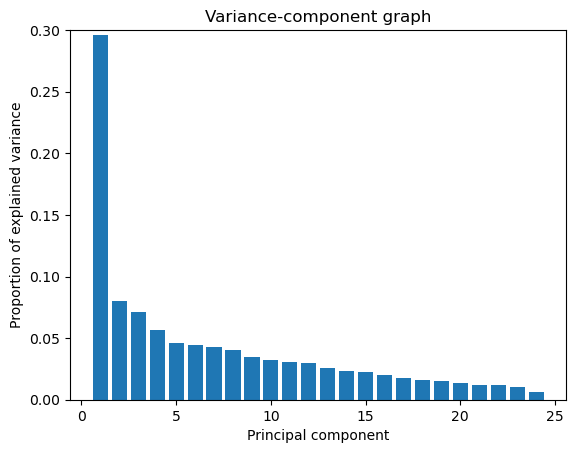

In [268]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
pca1 = PCA(n_components=24)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_pca = pca1.fit_transform(X_train_scaled)
    

plt.bar(range(1,25), pca1.explained_variance_ratio_, align='center')
plt.title('Variance-component graph')
plt.xlabel('Principal component')
plt.ylabel('Proportion of explained variance')
plt.ylim(0,0.3)
plt.show()


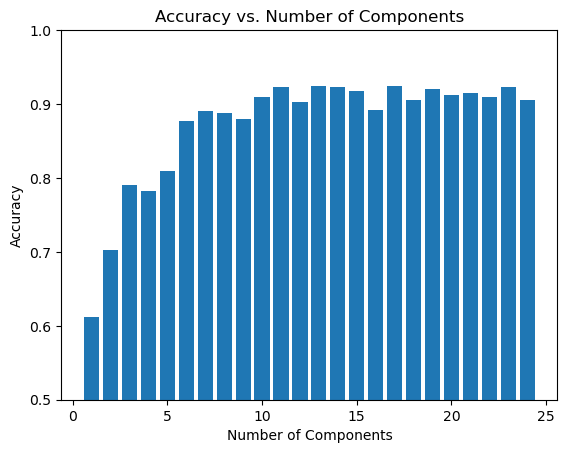

In [275]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

clf = LogisticRegression(random_state=0)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

scores=[]
num_components = []

for i in range(1, 25):
    pca = PCA(n_components=i)
    fold_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        clf.fit(X_train_pca, y_train)

        y_pred_fold = clf.predict(X_test_pca)

        fold_scores.append(accuracy_score(y_test, y_pred_fold))

    avg_score = sum(fold_scores) / len(fold_scores)

    num_components.append(i)
    scores.append(avg_score)


# Create bar graph
plt.bar(num_components, scores)
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)
plt.show()



In [270]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

svm = SVC(kernel='linear')

X_transformed = lda.fit_transform(X, y)
svm.fit(X_transformed, y)

scores = cross_val_score(svm, X_transformed, y, cv=10)
print("Accuracy of the SVM model with LDA transformation:", np.mean(scores)*100)


Accuracy of the SVM model with LDA transformation: 98.5


In [271]:
#LDA + GRADIENT BOOSTING
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

scores = cross_val_score(gb_model, X_transformed, y, cv=10)
print("Accuracy of the gradient boosting on LDA model:", np.mean(scores)*100)


Accuracy of the gradient boosting on LDA model: 98.5


In [ ]:
#mrmr
#-----------------------------------------------------------------------------------------------------------------------------

In [273]:
from mrmr import mrmr_classif
y_true = []
y_pred = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    selected_features = mrmr_classif(X_train, y_train, K=8)

    X_train_mrmr = X_train.loc[:, selected_features]
    X_test_mrmr = X_test.loc[:, selected_features]

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_mrmr, y_train)

    y_pred_fold = model.predict(X_test_mrmr)

    y_true.extend(y_test)
    y_pred.extend(y_pred_fold)


accuracy = accuracy_score(y_true, y_pred)
print("Accuracy: {:.4f}".format(accuracy))
print(selected_features)

100%|██████████| 8/8 [00:00<00:00, 21.69it/s]


Accuracy: 0.9825
['hemo', 'sg', 'pcv', 'dm', 'htn', 'al', 'rc', 'sod']
